In [1]:
#import numpy as np
#import matplotlib.pyplot as plt
import yaml, sys #os, sys, yaml
sys.path.insert(0,'../')
#import StatPol as SP, 
import Routines as R
#basepath = os.getcwd()

# Data to be analyzed
We construct various dictionaries with the results provided by Qchem (`HG_data`),
the results from MRChem (`MW_data`) and the data from PSP calculations (`BG_data`).
The latter is a dictionary with a further level indicating the family of the PSP chosen for the study. We also indicate, for each of the dataset, the molecules that are missing in the other reference data.

## Load reference data from HG supplementary information

In [2]:
HG_data=yaml.load(open('../HG Dataset/hg_data.yaml'))
# set the study for H to sp
HG_data['H']['spin_pol'] = 'sp'

In [3]:
HG_data['CO']

{'CCSD(T)': [1.753, 1.753, 2.283],
 'field_int': 0.01,
 'lda-SPW92': [1.872, 1.872, 2.358],
 'lda-Slater': [1.993, 1.993, 2.49],
 'mpol_ref': '1',
 'pbe': [1.856, 1.856, 2.363],
 'pbe0': [1.778, 1.778, 2.274],
 'spin_pol': 'nsp'}

Distinguish between closed shell and open shell molecules

In [4]:
open_shell=[mol for mol in HG_data if int(HG_data[mol]['mpol_ref']) != 1]
closed_shell=[mol for mol in HG_data if int(HG_data[mol]['mpol_ref']) == 1]

## Load Multiwavelet data with finite-differences

In [5]:
MWdata=yaml.load(open('../mw_data_0001v2.yaml'))
MW_data={mol:{xcref: MWdata[mol][xc]['diagonal'] for xcref,xc in [('lda-SPW92','lda'),('pbe','pbe')]} for mol in MWdata}

In [6]:
MW_data['co']

{'lda-SPW92': [1.868431750384668, 1.8684317500142003, 2.3535110461925104],
 'pbe': [1.8532465936431202, 1.8532465936431202, 2.359389168196766]}

Find the data which are not present in the MW dictionary

In [7]:
MW_missing=set()
for mol in HG_data:
    if mol.lower() not in MW_data:
        print ('Molecule "'+mol+'" not present in MRchem data')
        MW_missing.add(mol)

Molecule "PS" not present in MRchem data
Molecule "CH3O" not present in MRchem data
Molecule "S2" not present in MRchem data
Molecule "SH" not present in MRchem data


## Load PSP data from BigDFT calculations
After loading the data only consider the molecules for which the value of alpha is converged according to the criterion of the Workflow.

In [8]:
def get_field(full_results,study):
    """
    Retrieve the value of the field that provided the tolerance of the options
    """
    tol=full_results['options']['atol']
    field=full_results[study]['alpha_convergence']
    if field is not None: field=field[0]['f']
    return tol,field
def alpha_is_reliable(full_results,study):
    """
    Provide a boolean stating if the given study has a reliable statical polarizability
    """
    tol,field=get_field(full_results,study)
    if field is None or field == 0.0001: return False
    return True

def study_matches(study,key):
    """
    Returns the rest of the tuple of the study
    """
    #case of a string
    if type(key) == type('a'): return [i for i in study if i != key]
    #case of a tuple
    return [i for i in study if i not in list(key)]

def get_result(full_results,study,key):
    null=(None,None,None)
    if study == 'options' or not alpha_is_reliable(full_results,study): return null
    dataname=study_matches(study,key)
    th=2 if type(key) == type('a') else 3-len(key)
    if len(dataname)> th: return null
    result=full_results[study]['alpha_convergence']
    tol,field=get_field(full_results,study)
    return result,dataname,field

def reformat_result(full_results,key):
    """
    Works with a name of a (psp) as key
    """
    res={}
    import numpy
    for study in full_results:
        result,dataname,field = get_result(full_results,study,key)
        if result is None: continue
        alpha=numpy.array(result[1])*R.AuToA
        st=tuple(dataname)
        mol=st[0]
        xc=st[1] if st[1] != 'lda_pw' else 'lda-SPW92'
        res.setdefault(mol,{})
        res[mol].update({xc:alpha,xc+'-f':field})
    return res

In [9]:
full_results = yaml.load(open('full_results.yaml'))

In [10]:
full_results[('CO','pbe','hgh_k')]

{'alpha_convergence': ({'f': 0.005, 'rmult': 7.0},
  [12.509689000000002, 12.509689000000002, 15.9052996]),
 'input_gs': {'dft': {'gnrm_cv': 1e-06,
   'hgrids': 0.3,
   'ixc': 11,
   'rmult': [5.0, 9.0]}},
 'posinp': {'positions': [{'C': [0.0, 0.0, 0.0], 'frag': ['molecule', '0']},
   {'O': [0.0, 0.0, 1.1282], 'frag': ['molecule', '0']}],
  'units': 'angstroem'}}

In [11]:
# Failed rmult convergence for alpha, inform (this should rather go in the workflow detection nb)
for s in full_results:
    if s == 'options': continue
    tol,field=get_field(full_results,s)
    if field is None: print (s,'not_converged in size')
    if field == 0.0001: print (s,'not converged in field')

(('OH', 'pbe', 'nlcc_aw'), 'not converged in field')
(('BeH', 'pbe', 'nlcc_ss'), 'not_converged in size')
(('OH', 'pbe', 'hgh_k'), 'not_converged in size')
(('BN', 'lda_pw', 'hgh_k'), 'not converged in field')
(('PS', 'lda_pw', 'hgh_k'), 'not converged in field')
(('PS', 'pbe', 'nlcc_aw'), 'not converged in field')
(('C2H', 'pbe', 'hgh_k'), 'not_converged in size')
(('CH3O', 'pbe', 'nlcc_ss'), 'not_converged in size')
(('OH', 'pbe', 'nlcc_ss'), 'not converged in field')
(('CH3O', 'pbe', 'nlcc_aw'), 'not converged in field')
(('BN', 'pbe0', 'hgh_k'), 'not converged in field')
(('CH3O', 'lda_pw', 'hgh_k'), 'not_converged in size')
(('BN', 'pbe', 'hgh_k'), 'not converged in field')
(('PS', 'pbe', 'hgh_k'), 'not converged in field')
(('BN', 'pbe', 'nlcc_ss'), 'not converged in field')
(('OH', 'lda_pw', 'hgh_k'), 'not converged in field')
(('CH3O', 'pbe0', 'hgh_k'), 'not_converged in size')
(('BN', 'pbe', 'nlcc_aw'), 'not converged in field')
(('OH', 'pbe0', 'hgh_k'), 'not_converged in size

All the studies with convergence problem are in the open_shell sector of the database

In [12]:
for s in full_results:
    if s[0] in closed_shell:
        tol,field=get_field(full_results,s)
        if field is None: print (s,'not_converged in size')
        if field == 0.0001: print (s,'not converged in field')

Reformat the dictionary of the data per family of PSP

In [13]:
BG_data={}
for psp in ['hgh_k','nlcc_aw','nlcc_ss']:
    BG_data[psp]=reformat_result(full_results,(psp))

In [14]:
BG_data['hgh_k']['CO']

{'lda-SPW92': array([1.87139847, 1.87139847, 2.35082149]),
 'lda-SPW92-f': 0.005,
 'pbe': array([1.85374463, 1.85374463, 2.3569222 ]),
 'pbe-f': 0.005,
 'pbe0': array([1.77981528, 1.77981528, 2.27027629]),
 'pbe0-f': 0.005}

Check which molecules are still missing in the various data

In [15]:
missing={}
for psp in BG_data:
    missing[psp]=set()
    for mol in HG_data:
        if mol not in BG_data[psp]:
            print ('Molecule "'+mol+'" not present in BigDFT data with psp "'+psp+'"')
            missing[psp].add(mol)
BG_missing={'HG':missing}

Molecule "LiH" not present in BigDFT data with psp "nlcc_aw"
Molecule "BN" not present in BigDFT data with psp "nlcc_aw"
Molecule "CH2-t" not present in BigDFT data with psp "nlcc_aw"
Molecule "Be" not present in BigDFT data with psp "nlcc_aw"
Molecule "NaLi" not present in BigDFT data with psp "nlcc_aw"
Molecule "Na" not present in BigDFT data with psp "nlcc_aw"
Molecule "BeH2" not present in BigDFT data with psp "nlcc_aw"
Molecule "OH" not present in BigDFT data with psp "nlcc_aw"
Molecule "PS" not present in BigDFT data with psp "nlcc_aw"
Molecule "SO-trip" not present in BigDFT data with psp "nlcc_aw"
Molecule "He" not present in BigDFT data with psp "nlcc_aw"
Molecule "LiBH4" not present in BigDFT data with psp "nlcc_aw"
Molecule "CH3O" not present in BigDFT data with psp "nlcc_aw"
Molecule "Li2" not present in BigDFT data with psp "nlcc_aw"
Molecule "Ne" not present in BigDFT data with psp "nlcc_aw"
Molecule "NaCN" not present in BigDFT data with psp "nlcc_aw"
Molecule "BeH" not 

In [16]:
missing={}
for psp in BG_data:
    missing[psp]=set()
    for mol in BG_data[psp]:
        if mol.lower() not in MW_data:
            print ('Molecule "'+mol+'" not present in MWdata but present in BigDFT with psp "'+psp+'"')
            missing[psp].add(mol)
BG_missing['MW']=missing    

Molecule "CH2" not present in MWdata but present in BigDFT with psp "nlcc_aw"
Molecule "S2" not present in MWdata but present in BigDFT with psp "nlcc_aw"
Molecule "SH" not present in MWdata but present in BigDFT with psp "nlcc_aw"
Molecule "SO" not present in MWdata but present in BigDFT with psp "nlcc_aw"
Molecule "CH2" not present in MWdata but present in BigDFT with psp "nlcc_ss"
Molecule "CH2" not present in MWdata but present in BigDFT with psp "hgh_k"
Molecule "PS" not present in MWdata but present in BigDFT with psp "hgh_k"
Molecule "S2" not present in MWdata but present in BigDFT with psp "hgh_k"
Molecule "SH" not present in MWdata but present in BigDFT with psp "hgh_k"
Molecule "SO" not present in MWdata but present in BigDFT with psp "hgh_k"


# Data Analysis, comparison between results
We have now the possiblity to compare the data wrt to the reference values.
To do that we define the function which plots traditional scatterpolots indicating the differences and box-and-whiskers plots to have the vision at-a-glance of the compared data.


In [17]:
def relative_error(alpha,alpha_ref):
    """
    Provide the relative error
    """
    return 100.0*(alpha-alpha_ref)/alpha_ref

def relative_errors_and_uncertainties(alpha,alpha_ref,tol):
    """
    Provide the relative error and its uncertainty given the absolute value of the tolerance 
    in alpha
    """
    import numpy
    alp=numpy.array(alpha)
    err=relative_error(alp,alpha_ref)
    sigma=relative_error(tol+alpha_ref,alpha_ref)
    return err,sigma

def alpha_squared_discrepancy(alpha,alpha_ref,tol):
    """
    Give the squared discrepancy on the trace of the statical polarizability
    """
    import numpy
    err,sigma=relative_errors_and_uncertainties(alpha,alpha_ref,tol)
    return numpy.mean(err**2),numpy.mean(2.0*err*sigma)

def alpha_relative_discrepancy(alpha,alpha_ref,tol):
    """
    Give the relative discrepancy on the value of the statical polarizability ( the physical observable)
    """
    import numpy
    return relative_errors_and_uncertainties(numpy.mean(alpha),numpy.mean(alpha_ref),tol)

def compare_datasets(ref,data,xc,exclude=[],include=None,revert_ref=False):
    res={}
    for mol in data:
        ignore_mol= mol in exclude or (include is not None and mol not in include)
        if xc not in data[mol] or ignore_mol: continue
        alpha=data[mol][xc]
        molr = mol.lower() if mol not in ref else mol
        if molr not in ref: continue
        alpha_ref=ref[molr][xc]
        dataname=(mol,xc)
        err=alpha_relative_discrepancy(alpha,alpha_ref,1.e-3)
        if revert_ref: err=alpha_relative_discrepancy(alpha_ref,alpha,1.e-3)
        field=data[mol].get(xc+'-f')
        res[dataname]={'err':err,'key':dataname,'field':field}
    return res

def reformat_comparison_for_plot(result,ids=None):
    from futile.Utils import sort_lists
    data=result.keys()
    data.sort()
    #take the first data as an exemple
    template=data[0]
    #build the different levels
    labels=['data']
    if len(template) > 1: labels=list(set(tuple(d[1:]) for d in data))
    labels.sort()
    toplot=[]
    for i,lev in enumerate(labels):
        if lev=='data':
            mols=[d[0] for d in data]
            keys=[tuple([m]) for m in mols]
        else:
            mols=[ d[0] for d in data if tuple(d[1:])==lev]
            keys=[tuple([m]+list(lev)) for m in mols]
        curve=[result[k]['err'][0] for k in keys]
        studies=[result[k]['key'] for k in keys]
        fields=[result[k]['field'] for k in keys]
        mols,curve,studies,fields=sort_lists(1,False,mols,curve,studies,fields)
        id = str(lev) if ids is None else ids[i]
        toplot.append({'mols':mols,'data':curve,'keys':studies,'fields':fields,'label':id})
    return toplot

#one curve per tuple size
def plot_data(data):
    import matplotlib.pyplot as plt
    for curve in data:
        lev=curve['label']
        plt.plot(curve['mols'],curve['data'],'o',label=curve['label'])
        plt.xticks(rotation='vertical')
        ax = plt.axes()  
        ax.yaxis.grid(linestyle='--') # horizontal lines
        ax.xaxis.grid(linestyle='--') # vertical lines
        plt.legend(loc='best')
    return plt

Make a Box and whisker plot to compare the data

In [22]:
def write_fliers_names(ax,data,allfliers):
    import numpy as np
    from futile.Utils import sort_lists
    analyse=zip(data,allfliers)
    analyse.reverse()
    for orig,fliers in analyse:
        ttx=fliers.get_xdata()
        tty=fliers.get_ydata()
        #get original names
        lup=[orig['mols'][orig['data'].index(d)] for d in ttx]
        for i, txt in enumerate(lup):
            ax.annotate(txt, (ttx[i], tty[i]+0.2),rotation=90)
        tt=np.array(orig['data'])
        mre=np.mean(tt)
        std=np.std(tt)
        rmsre2=np.mean(tt**2)
        std2=np.std(tt**2)
        print ('Study: '+orig['label']+20*' '+'#'+20*'-')
        print (10*' '+'Total Number of Molecules: '+str(len(orig['mols'])))
        print (10*' '+'MRE: '+str(mre)+' +/- '+str(std))
        print (10*' '+'RMSRE: '+str(np.sqrt(rmsre2))+' +/- '+str(0.5/np.sqrt(rmsre2)*std2))
        if len(ttx) > 0: 
            tt,lup2=sort_lists(0,True,ttx,lup)
            print (10*' '+'There are '+str(len(ttx))+' outliers: '+str(list(lup2)))
        print (' ')

def plot_box_and_whisker(data): 
    import matplotlib.pyplot as plt
    toplot=[d['data']for d in data]
    labels=[d['label'] for d in data]
    tt=plt.boxplot(toplot,vert=False,patch_artist=False,labels=labels,meanline=True,showmeans=True)
    ax = plt.axes()
    fliers=tt['fliers']
    #fliers.reverse()
    write_fliers_names(ax,data,fliers)
    return plt


In [23]:
def plot_field_intensities(data):
    import matplotlib.pyplot as plt
    for curve in data:
        plt.plot(curve['fields'],curve['data'],'o',label=curve['label'])
        plt.xticks(rotation='vertical')
        ax = plt.axes()  
        ax.yaxis.grid(linestyle='--') # horizontal lines
        ax.xaxis.grid(linestyle='--') # vertical lines
        plt.title('Error vs. field intensities')
    return plt

In [24]:
def comparison_of_data(restrict_to=None):
    for xc in ['lda-SPW92','pbe']:
        psps=['hgh_k']
        if xc == 'pbe': psps+= ['nlcc_aw','nlcc_ss']
        MW_HG=compare_datasets(MW_data,HG_data,xc,revert_ref=True,include=restrict_to)
        a=reformat_comparison_for_plot(MW_HG,ids=['MW vs HG'])
        fields=[]
        for psp in psps:
            MW_BG1=compare_datasets(MW_data,BG_data[psp],xc,exclude=MW_missing,include=restrict_to)#,exclude=open_shell)
            b=reformat_comparison_for_plot(MW_BG1,ids=[psp+' vs MW'])
            a+=b
            fields+=b
            HG_BG=compare_datasets(HG_data,BG_data[psp],xc,exclude=MW_missing,include=restrict_to)
            a+=reformat_comparison_for_plot(HG_BG,ids=[psp+' vs HG'])
        pp=plot_data(a)
        pp.title('Comparison for xc: '+xc)
        pp.show()
        pp=plot_box_and_whisker(a)
        pp.show()
        pp=plot_field_intensities(fields)
        pp.show()

In [25]:
comparison_of_data()

ImportError: cannot import name sort_lists

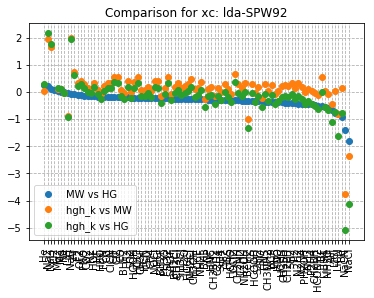

Study: hgh_k vs HG                    #--------------------
          Total Number of Molecules: 91
          MRE: -0.19217560081155874 +/- 0.8446200915016886
          RMSRE: 0.8662069963441789 +/- 1.8892017855934804
          There are 8 outliers: ['NaCN', 'NaCl', 'LiCN', 'BeH2', 'AlF', 'NaLi', 'NaH', 'Na2']
 
Study: hgh_k vs MW                    #--------------------
          Total Number of Molecules: 91
          MRE: 0.11711407723187447 +/- 0.6396559359344881
          RMSRE: 0.6502887231546457 +/- 1.279263085943052
          There are 9 outliers: ['NaCN', 'NaCl', 'BeH2', 'LiH', 'LiCN', 'AlF', 'NaLi', 'Na2', 'NaH']
 
Study: MW vs HG                    #--------------------
          Total Number of Molecules: 92
          MRE: -0.3060908443215714 +/- 0.2710175926177804
          RMSRE: 0.40883020984979773 +/- 0.4977088996150849
          There are 9 outliers: ['NaCl', 'NaCN', 'Be', 'LiCN', 'LiCl', 'AlF', 'NaLi', 'Na2', 'He']
 


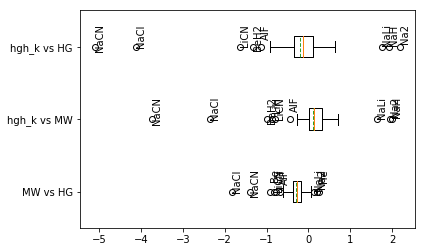

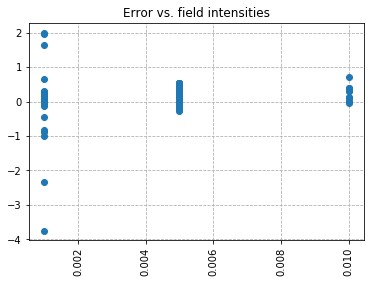

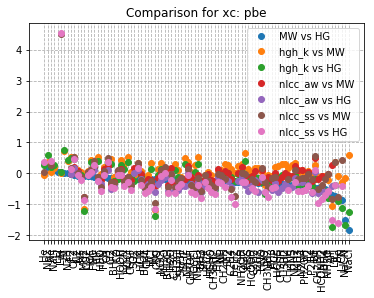

Study: nlcc_ss vs HG                    #--------------------
          Total Number of Molecules: 74
          MRE: -0.3312553062066654 +/- 0.6876881820382114
          RMSRE: 0.7633119372871694 +/- 1.5640256924088587
          There are 3 outliers: ['Be', 'AlF', 'LiH']
 
Study: nlcc_ss vs MW                    #--------------------
          Total Number of Molecules: 74
          MRE: -0.08157124119014869 +/- 0.6225218754327754
          RMSRE: 0.6278434142217637 +/- 1.8582451757143656
          There are 1 outliers: ['LiH']
 
Study: nlcc_aw vs HG                    #--------------------
          Total Number of Molecules: 77
          MRE: -0.31235025286934603 +/- 0.22048397979893852
          RMSRE: 0.3823295251684378 +/- 0.17768622803316134
 
Study: nlcc_aw vs MW                    #--------------------
          Total Number of Molecules: 77
          MRE: -0.06638306873658323 +/- 0.2054539354166054
          RMSRE: 0.21591209181761123 +/- 0.17192619217600866
          There ar

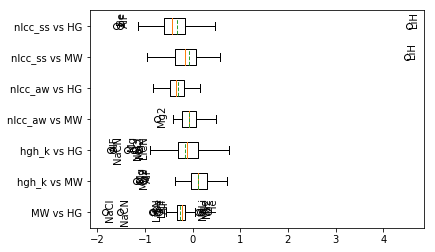

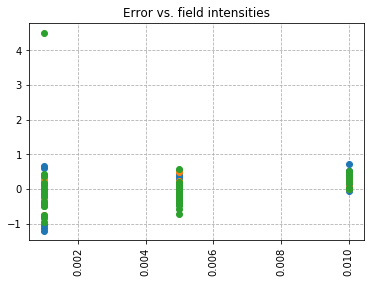

In [17]:
comparison_of_data(restrict_to=closed_shell)

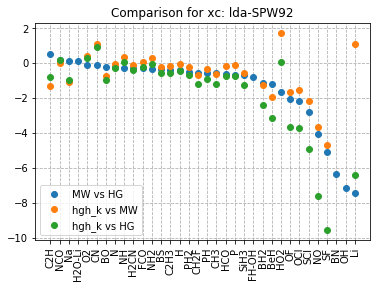

Study: hgh_k vs HG                    #--------------------
          Total Number of Molecules: 30
          MRE: -1.7357542939499804 +/- 2.4413854297427213
          RMSRE: 2.9955309688811176 +/- 3.357189264036353
          There are 4 outliers: ['SF', 'NO', 'Li', 'SCl']
 
Study: hgh_k vs MW                    #--------------------
          Total Number of Molecules: 30
          MRE: -0.6127313912513751 +/- 1.2976307223413694
          RMSRE: 1.4350209926649262 +/- 1.5881261751677331
          There are 2 outliers: ['SF', 'NO']
 
Study: MW vs HG                    #--------------------
          Total Number of Molecules: 34
          MRE: -1.4223945000403933 +/- 2.083563084163408
          RMSRE: 2.5227844219103805 +/- 2.8457862872192945
          There are 5 outliers: ['Li', 'OH', 'BN', 'SF', 'NO']
 


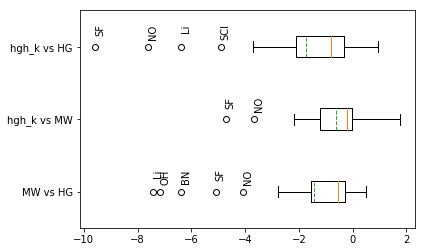

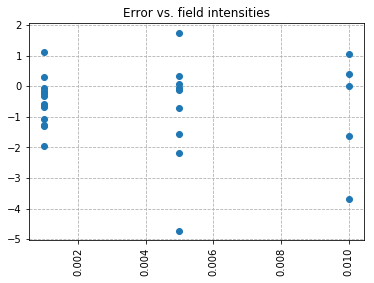

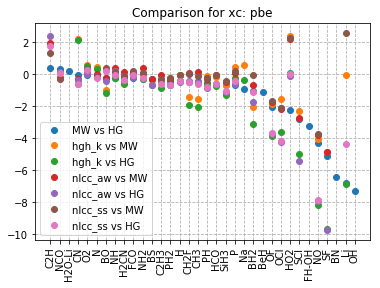

Study: nlcc_ss vs HG                    #--------------------
          Total Number of Molecules: 25
          MRE: -1.0407631947009137 +/- 1.9368483835718517
          RMSRE: 2.1987654919042523 +/- 2.9168034384574297
          There are 5 outliers: ['NO', 'Li', 'OCl', 'OF', 'C2H']
 
Study: nlcc_ss vs MW                    #--------------------
          Total Number of Molecules: 25
          MRE: -0.08745327115173664 +/- 1.1982142056202958
          RMSRE: 1.2014014138436062 +/- 1.3018974583678777
          There are 6 outliers: ['NO', 'OCl', 'OF', 'C2H', 'HO2', 'Li']
 
Study: nlcc_aw vs HG                    #--------------------
          Total Number of Molecules: 27
          MRE: -1.382352557190284 +/- 2.5919699309963526
          RMSRE: 2.9375511426287977 +/- 3.65507051058841
          There are 6 outliers: ['SF', 'NO', 'SCl', 'OCl', 'OF', 'C2H']
 
Study: nlcc_aw vs MW                    #--------------------
          Total Number of Molecules: 27
          MRE: -0.4668767237

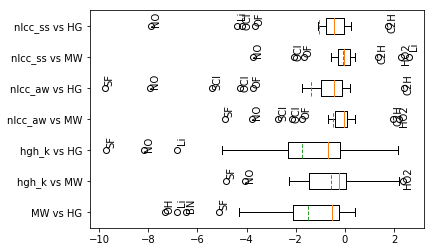

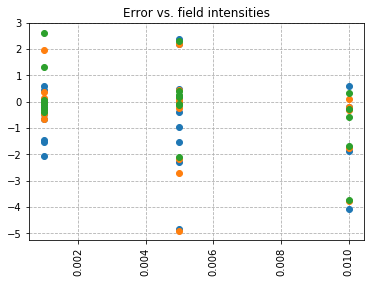

In [18]:
comparison_of_data(restrict_to=open_shell)

## Comparison BigDFT vs HG for closed shell

We want to understand if the differences can be attributed to a different choice of the intensity of the field

In [71]:
outliers_lda = ['NaCN', 'NaCl', 'LiCN', 'BeH2', 'AlF', 'NaLi', 'NaH', 'Na2']
outliers_pbe = ['Be', 'AlF', 'LiH']

In [72]:
xc = 'lda_pw'

for mol in outliers_lda:
    ss = mol+': HG_field = '+str(HG_data[mol]['field_int'])+' '
    for study in full_results:
        if study[0] == mol and study[1] == xc:
            ss += str(study[2])+'field = '+str(get_field(full_results,study)[1])
    print  ss

NaCN: HG_field = 0.01 hgh_kfield = 0.001
NaCl: HG_field = 0.001 hgh_kfield = 0.001
LiCN: HG_field = 0.01 hgh_kfield = 0.001
BeH2: HG_field = 0.01 hgh_kfield = 0.001
AlF: HG_field = 0.01 hgh_kfield = 0.001
NaLi: HG_field = 0.001 hgh_kfield = 0.001
NaH: HG_field = 0.001 hgh_kfield = 0.001
Na2: HG_field = 0.001 hgh_kfield = 0.001


The values of the field intensity are equal only for NaLi,NaH,Na2. This molecules have to be inspected further.
Probabibly there is some problem related to the psp for Na.

In [74]:
xc = 'pbe'

for mol in outliers_pbe:
    ss = mol+': HG_field = '+str(HG_data[mol]['field_int'])+' '
    for study in full_results:
        if study[0] == mol and study[1] == xc:
            ss += str(study[2])+'field = '+str(get_field(full_results,study)[1])+' '
    print  ss

Be: HG_field = 0.01 nlcc_ssfield = 0.001 hgh_kfield = 0.001 
AlF: HG_field = 0.01 nlcc_awfield = 0.001 nlcc_ssfield = 0.001 hgh_kfield = 0.001 
LiH: HG_field = 0.001 nlcc_ssfield = 0.001 hgh_kfield = 0.001 


Field intensity equal for LiH...check further in this case

In [57]:
get_field(full_results,('NaCN','lda_pw','hgh_k'))

(0.001, 0.001)

In [53]:
full_results[('NaCN','lda_pw','hgh_k')]['alpha_convergence']

({'f': 0.001, 'rmult': 7.0},
 [32.593500000000056, 31.128999999999962, 25.291824999999996])